In [43]:
import numpy as np
import scipy.misc
import glob
import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers.merge import Concatenate
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from sklearn.model_selection import train_test_split
from io import BytesIO
from IPython import display
from PIL import Image

def display_image(arr):
    b = BytesIO()
    Image.fromarray(np.uint8(arr)).save(b, format='png')
    data = b.getvalue()
    display.display(display.Image(data=data, format='png', embed=True))

labels = ['gyoku', 'ou', 'kin', 'gin', 'kei', 'kyo', 'kaku', 'hi', 'fu', 'narigin', 'narikei', 'narikyo', 'uma', 'ryu', 'to']

# input image dimensions
img_rows, img_cols = 64, 64
IMG_ROWS, IMG_COLS = 64, 64
input_shape = (img_rows, img_cols, 1)

series_imgs = []
series_labels = []
for i, series in enumerate(sorted(glob.glob("../data/koma/*.npz"))):
    file = np.load(series)
    print(series)
    series_imgs.append(file['imgs'].astype(np.float32))
    series_labels.append(file['labels'])
num_series = len(series_imgs)

../data/koma/01.npz
../data/koma/02.npz
../data/koma/03.npz
../data/koma/04.npz
../data/koma/05.npz
../data/koma/06.npz
../data/koma/07.npz
../data/koma/08.npz
../data/koma/09.npz
../data/koma/10.npz
../data/koma/11.npz
../data/koma/12.npz
../data/koma/13.npz
../data/koma/14.npz
../data/koma/15.npz
../data/koma/16.npz
../data/koma/17.npz
../data/koma/18.npz
../data/koma/19.npz
../data/koma/20.npz
../data/koma/21.npz
../data/koma/22.npz
../data/koma/23.npz
../data/koma/24.npz
../data/koma/25.npz
../data/koma/26.npz
../data/koma/27.npz


In [44]:
# load all
x_all = np.empty((0, img_rows, img_cols))
y_all = np.empty((0, 2), np.int32)
for i in range(num_series):
    num_imgs = len(series_imgs[i])
    x_all = np.r_[x_all, series_imgs[i]]
    label_indices = []
    for j, label in enumerate(series_labels[i]):
        label_indices.append(labels.index(label))
    label_and_series = np.c_[label_indices, np.full((num_imgs), i)]
    y_all = np.r_[y_all, label_and_series]

# num_classes = len(labels) * 2 + 1
num_classes = len(labels)

# # rot 180
# x_all = np.r_[x_all, np.rot90(x_all, 2, (1, 2))]
# y_rot = np.copy(y_all)
# y_rot[:, 0] += len(labels)
# y_all = np.r_[y_all, y_rot]

# # space
# space_imgs = np.load('../data/empty_cell.npz')['imgs'].astype(np.float32)
# x_all = np.r_[x_all, space_imgs]
# y_space = np.full((len(space_imgs), 2), [len(labels) * 2, num_series])
# y_all = np.r_[y_all, y_space]

# print(x_all.shape)
# print(y_all.shape)

# reshape to TF
x_all = x_all.reshape(x_all.shape[0], img_rows, img_cols, 1)
x_all = x_all.astype(np.float32)
x_all /= 255

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train[:, 0], num_classes)
y_test = keras.utils.to_categorical(y_test[:, 0], num_classes)

In [46]:
from scipy import ndimage

train_len = x_train.shape[0]

# distortion (gaussian noise)
# hard_noised = np.copy(x_train)
# soft_noised = np.copy(x_train)
hard_seed_1 = 1.0 * np.random.randn(train_len, IMG_ROWS, IMG_COLS, 1)
hard_seed_2 = 1.5 * np.random.randn(train_len, IMG_ROWS, IMG_COLS, 1)
hard_seed_3 = 1.5 * np.random.randn(train_len, IMG_ROWS, IMG_COLS, 1)
soft_seed = 0.1 * np.random.randn(train_len, IMG_ROWS, IMG_COLS, 1)
seed = np.absolute(np.r_[hard_seed_1, hard_seed_2, hard_seed_3, soft_seed])
seed = ndimage.gaussian_filter(seed, 1)
# noised = np.r_[np.copy(x_train), np.copy(x_train), np.copy(x_train), np.copy(x_train)]
noised = np.r_[x_train, x_train, x_train, x_train]
noised += seed
noised /= (seed + 1)

x_train = np.r_[x_train, noised]
y_train = np.r_[y_train, y_train, y_train, y_train, y_train]

print(x_train.shape)
print(y_train.shape)

# #  distortion (inverse)
# choice = np.random.rand(train_len)
# x_train[np.where(choice > 0.5)] *= -1
# x_train[np.where(choice > 0.5)] += 1

(1665, 64, 64, 1)
(1665, 15)


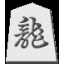

13


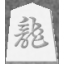

13


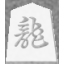

13


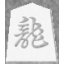

13


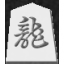

13


In [47]:
for i in range(5):
    display_image(x_train[i*333 + 1, :, :, 0] * 255)
    print(np.argmax(y_train[i*333 + 1]))

In [48]:
from keras.models import load_model
model = load_model("../etl8_noise_smoose.h5")

In [49]:
for i in range(9):
    model.pop()
for l in model.layers:
    l.trainable = False

In [50]:
model.add(Dense(1024, name='shogi_dense_1'))
model.add(BatchNormalization(name='shogi_norm_1'))
model.add(PReLU(name='shogi_prelu_1'))
model.add(Dropout(0.25, name='shogi_dropout_1'))
model.add(Dense(1024, name='shogi_dense_2'))
model.add(BatchNormalization(name='shogi_norm_2'))
model.add(PReLU(name='shogi_prelu_2'))
model.add(Dropout(0.5, name='shogi_dropout_2'))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='shogi_dense_out'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 62, 62, 32)        123008    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 29, 29, 64)        53824     
__________

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=[0.55, 1.0],
    width_shift_range=0.15,
    height_shift_range=0.15,
    fill_mode="constant",
    cval=0.9
)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
BATCH_SIZE = 16
model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), steps_per_epoch=x_train.shape[0],
                    epochs=20, verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
1665/1665 [==============================] - 37s - loss: 0.1462 - acc: 0.9550 - val_loss: 1.1070 - val_acc: 0.7368
Epoch 2/20
1665/1665 [==============================] - 35s - loss: 0.1475 - acc: 0.9552 - val_loss: 1.2814 - val_acc: 0.7895
Epoch 3/20
1665/1665 [==============================] - 35s - loss: 0.1488 - acc: 0.9536 - val_loss: 1.0030 - val_acc: 0.8158
Epoch 4/20
1665/1665 [==============================] - 35s - loss: 0.1438 - acc: 0.9550 - val_loss: 1.2549 - val_acc: 0.7632
Epoch 5/20
1665/1665 [==============================] - 35s - loss: 0.1432 - acc: 0.9578 - val_loss: 1.2872 - val_acc: 0.7368
Epoch 13/20
1665/1665 [==============================] - 35s - loss: 0.1415 - acc: 0.9569 - val_loss: 1.0979 - val_acc: 0.7895
Epoch 14/20
1665/1665 [==============================] - 36s - loss: 0.1376 - acc: 0.9579 - val_loss: 1.4355 - val_acc: 0.7368
Epoch 15/20
1665/1665 [==============================] - 35s - loss: 0.1335 - acc: 0.9603 - val_loss: 1.4227 - val_a

In [58]:
model.save("../purple_etl5_noise.h5")

In [60]:
pred_res = model.predict(x_test)
res = np.array([np.argmax(r) for r in pred_res])
ans = np.array([np.where(y == 1)[0][0] for y in y_test])
print(res)
print(ans)
correct = np.where(res == ans)[0]
errors = np.where(res != ans)[0]
print(errors)

[14  1  7  6  6 13  0  7 12  0  6  8  2 14 13  6 13 11  0  9  8  1  0  6  4
  2  0  7  0  6  3  7 10  4  9 11 10  9]
[14  1  7  6  6 13  1  7 13  1  6  8  3 11 13  6 13 11  0  9  9  1  1  6  4
  2  1  7  0  6  3  7  9  4  9 11 10  5]
[ 6  8  9 12 13 20 22 26 32 37]


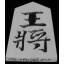

gyoku


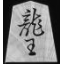

uma


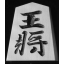

gyoku


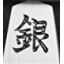

kin


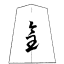

to


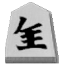

fu


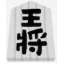

gyoku


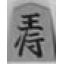

gyoku


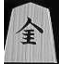

narikei


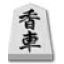

narigin


In [61]:
for e in errors:
    display_image(np.uint8(x_test[e] * 255)[:, :, 0])
    if len(labels) > res[e]:
        print(labels[res[e]])
    else:
        print("p")
        print(labels[res[e] - len(labels)])